In [1]:
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from functions import *
from functions_plots import *
from collections import Counter
from matplotlib.ticker import MaxNLocator

In [2]:
# Load data
data_folder_path = Path('../data/')
data = pd.read_csv(data_folder_path / 'data_train_all.csv')
data_columns = pd.read_csv(data_folder_path / 'data_train_all_columns.csv')

print("Training data length:", len(data))

predictor_columns = data_columns[data_columns['column_type'].isin(['predictor_n_grams', 'predictor_continuous'])]['column_name'].tolist()
print(f"Number of predictor columns: {len(predictor_columns)}")

#target_columns = data_columns[data_columns['column_type'] == 'target']['column_name'].tolist()
target_columns = ['main_genre']
print(f"Target columns: {target_columns}")

Training data length: 255606
Number of predictor columns: 119
Target columns: ['main_genre']


In [3]:
# Select target variable and type
target_variable = 'main_genre'
target_type = 'multiclass'

# Drop NaN values in target variable from entire dataset
if data[target_variable].isna().any():
    data = data[data[target_variable].notna()].reset_index(drop=True)
    print(f"Rows after dropping NaN in {target_variable}: {len(data)}")
else:
    print(f"No rows dropped, no missing values")

No rows dropped, no missing values


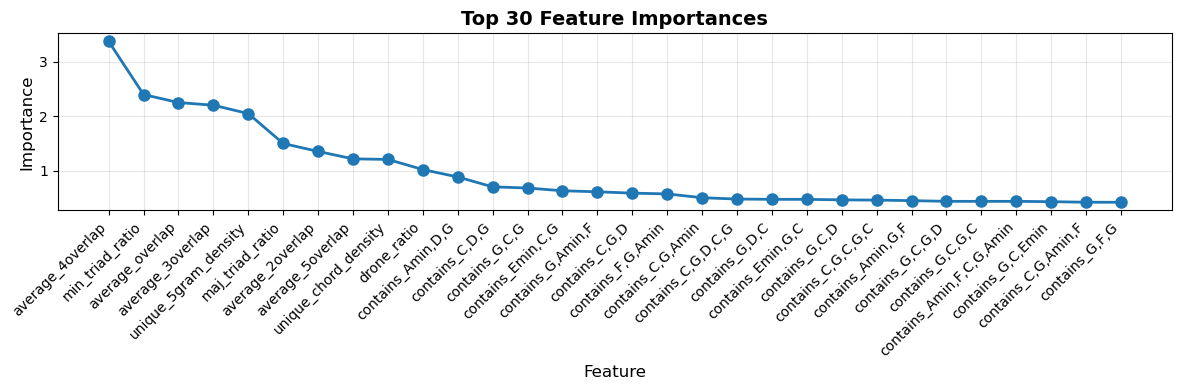

In [4]:
# select features here
path_feature_selection = Path('../feature_engineering/feature_selection/feature_selection_csv')
feature_selection = pd.read_csv(path_feature_selection / f'lasso_feature_importance_{target_variable}.csv')

# Plot feature importance for top N features
ax = plot_feature_importance_df(feature_selection, top_n=30, figsize=(12,4))

In [5]:
# Select top N features or comment out to use all features
my_features = feature_selection.head(10)
my_features = my_features[my_features['feature'] != 'average_overlap']
my_features = my_features[my_features['feature'] != 'unique_5gram_density']
predictor_columns = list(my_features['feature'])
predictor_columns

['average_4overlap',
 'min_triad_ratio',
 'average_3overlap',
 'maj_triad_ratio',
 'average_2overlap',
 'average_5overlap',
 'unique_chord_density',
 'drone_ratio']

In [6]:
# Make dataframes with predictor features
data_X = data[predictor_columns]
data_X.head(5)

,average_4overlap,min_triad_ratio,average_3overlap,maj_triad_ratio,average_2overlap,average_5overlap,unique_chord_density,drone_ratio
0,3.000000,0.500000,1.258427,0.500000,0.000000,1.241379,0.043478,0.500000
1,1.517241,0.242424,1.866667,0.757576,1.000000,1.107143,0.151515,0.636364
2,1.260000,0.148148,1.235294,0.851852,1.576923,1.551020,0.129630,0.685185
3,3.000000,0.500000,0.492308,0.500000,0.500000,0.507937,0.058824,0.500000
4,1.467742,0.151515,1.111111,0.772727,1.609375,1.868852,0.151515,0.621212


In [7]:
# When modeling genre, we need to encode the labels (all other target variables are numeric already)
le = LabelEncoder()
data_y = le.fit_transform(data[target_variable])

In [8]:
# looking at the relative genre frequencies, to get an idea of what a baseline dummy should be able to predict
genre_counter = Counter(data.main_genre)
genre_counter_total = sum(genre_counter.values())
genre_counter_relative = Counter({k : v/genre_counter_total for k, v in genre_counter.items()})
genre_counter_relative

Counter({'pop': 0.2414301698708168,
         'rock': 0.19097752008951277,
         'country': 0.1486467453815638,
         'alternative': 0.14038794081516084,
         'pop rock': 0.11276730593178563,
         'punk': 0.04784316487093417,
         'metal': 0.03363379576379271,
         'rap': 0.028770842624977505,
         'soul': 0.02039075765044639,
         'jazz': 0.017570010093659775,
         'reggae': 0.010887850832922544,
         'electronic': 0.006693896074427048})

In [9]:
# Use StratifiedKFold for classification tasks
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=145)

In [10]:
print("Target variable:",target_variable)
results_dummy = evaluate_dummy_baseline(data_X, data_y, cv=cv, target_type=target_type, random_state=0, print_cv = True)

Target variable: main_genre

Evaluating Dummy Baseline...
Cross-validation folds: 5

Dummy Baseline - Multiclass Target
Parameters: strategy=most_frequent

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.2414 (+/- 0.0000)
Precision Micro               :  0.2414 (+/- 0.0000)




In [11]:
# Train and fit logistic regression model here (uses ridge regression for regression variables)
print("Predicting:",target_variable)
print("Using the features:",predictor_columns)
print("Using a logistic regression.")

results_lr = train_logistic_regression(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    random_state=42,
    print_cv = True
)

Predicting: main_genre
Using the features: ['average_4overlap', 'min_triad_ratio', 'average_3overlap', 'maj_triad_ratio', 'average_2overlap', 'average_5overlap', 'unique_chord_density', 'drone_ratio']
Using a logistic regression.

Training Logistic Regression/Ridge...
Cross-validation folds: 5

Logistic Regression - Multiclass Target
Parameters: C=1.0, penalty=l2, solver=lbfgs

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.2783 (+/- 0.0011)
F1 Micro                      :  0.2783 (+/- 0.0011)
Precision Micro               :  0.2783 (+/- 0.0011)
Recall Micro                  :  0.2783 (+/- 0.0011)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.2784 (+/- 0.0004)
F1 Micro                      :  0.2784 (+/- 0.0004)
Precision Micro               :  0.2784 (+/- 0.0004)
Recall Micro                  :  0.2784 (+/- 0.0004)




In [12]:
# Train and fit Lasso model here
print("Predicting:",target_variable)
print("Using the features:",predictor_columns)
print("Using a lasso regression.")

results_lasso = train_lasso(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    alpha=0.1,
    max_iter=5000,
    random_state=42,
    print_cv = True
)

Predicting: main_genre
Using the features: ['average_4overlap', 'min_triad_ratio', 'average_3overlap', 'maj_triad_ratio', 'average_2overlap', 'average_5overlap', 'unique_chord_density', 'drone_ratio']
Using a lasso regression.

📐 Training Lasso...
Cross-validation folds: 5

Lasso - Multiclass Target
Parameters: alpha=0.1, max_iter=5000

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.2783 (+/- 0.0011)
F1 Micro                      :  0.2783 (+/- 0.0011)
Precision Micro               :  0.2783 (+/- 0.0011)
Recall Micro                  :  0.2783 (+/- 0.0011)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.2784 (+/- 0.0003)
F1 Micro                      :  0.2784 (+/- 0.0003)
Precision Micro               :  0.2784 (+/- 0.0003)
Recall Micro                  :  0.2784 (+/- 0.0003)




In [13]:
# Train and fit Random Forests model here
print("Predicting:",target_variable)
print("Using the features:",predictor_columns)
print("Using a random forest model.")

results_rf = train_random_forest(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    n_estimators=100,
    max_depth=5,
    random_state=42,
    print_cv = True
)

Predicting: main_genre
Using the features: ['average_4overlap', 'min_triad_ratio', 'average_3overlap', 'maj_triad_ratio', 'average_2overlap', 'average_5overlap', 'unique_chord_density', 'drone_ratio']
Using a random forest model.

Training Random Forest...
Cross-validation folds: 5

Random Forest - Multiclass Target
Parameters: n_estimators=100, max_depth=5, min_samples_leaf=1

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.2846 (+/- 0.0011)
F1 Micro                      :  0.2846 (+/- 0.0011)
Precision Micro               :  0.2846 (+/- 0.0011)
Recall Micro                  :  0.2846 (+/- 0.0011)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.2858 (+/- 0.0002)
F1 Micro                      :  0.2858 (+/- 0.0002)
Precision Micro               :  0.2858 (+/- 0.0002)
Recall Micro                  :  0.2858 (+/- 0.0002)




In [14]:
# load the final test data
data_test = pd.read_csv(data_folder_path / 'data_test_all.csv')

X_test = data_test[predictor_columns]

le = LabelEncoder()
y_test = le.fit_transform(data_test[target_variable])

In [15]:
# final model choice: random forest using the features above
random_forest_classifier = RandomForestClassifier(n_estimators = 100,
                                                  max_depth = 5,
                                                  min_samples_split = 2,
                                                  min_samples_leaf = 1,
                                                  random_state = 42,
                                                  n_jobs = -1)

random_forest_classifier.fit(data_X,data_y)
y_pred = random_forest_classifier.predict(data_test[predictor_columns])
accuracy = accuracy_score(y_test,y_pred)

In [16]:
print(accuracy)

0.2847229919968076
